# Fraud Detection - Exploratory Data Analysis
## Minimal Viable EDA

**Project**: Credit Card Fraud Detection  
**Dataset**: Kaggle Credit Card Fraud Detection (284,807 transactions)  
**Goal**: Understand data quality, class imbalance, and key patterns

---

### What We'll Analyze:
1. ✅ **Data Quality Check** - Validate data integrity
2. ✅ **Class Imbalance Analysis** - Understand fraud vs normal distribution
3. ✅ **Amount Feature Analysis** - Statistical testing and patterns
4. ✅ **Outlier Detection** - Find anomalies using Isolation Forest


In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import IsolationForest
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid') if 'seaborn-v0_8-whitegrid' in plt.style.available else plt.style.use('default')
sns.set_palette("husl")
pd.options.display.float_format = '{:.2f}'.format

print("✓ All libraries imported successfully!")
print(f"✓ Pandas version: {pd.__version__}")
print(f"✓ NumPy version: {np.__version__}")


✓ All libraries imported successfully!
✓ Pandas version: 2.3.1
✓ NumPy version: 2.3.2


## Step 1: Load Data from Database


In [1]:
# Load data from SQLite database (from Phase 1)
from data_storage_setup import DataStorageManager

# Initialize storage manager
storage = DataStorageManager(project_root='./fraud_detection_project')

# Load data
df = storage.query_data("SELECT * FROM raw_transactions")

print(f"✓ Data loaded: {len(df):,} rows, {len(df.columns)} columns")
print(f"✓ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display first few rows
df.head()


✓ Directory structure created at: fraud_detection_project
✓ Data loaded: 284,807 rows, 31 columns
✓ Memory usage: 67.36 MB


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Step 2: Data Quality Analysis

Let's check for:
- Missing values
- Data types
- Duplicate rows
- Overall quality score


In [2]:
# 1. Check missing values
print("="*60)
print("1. MISSING VALUES")
print("="*60)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
print(f"Total missing values: {missing.sum()}")
print(f"Percentage: {missing_pct.sum():.2f}%\n")

# 2. Data types
print("="*60)
print("2. DATA TYPES")
print("="*60)
print(df.dtypes.value_counts())
print()

# 3. Duplicates
print("="*60)
print("3. DUPLICATE ROWS")
print("="*60)
duplicates = df.duplicated().sum()
duplicate_pct = (duplicates / len(df)) * 100
print(f"Duplicate rows: {duplicates:,} ({duplicate_pct:.2f}%)\n")

# 4. Calculate quality score
quality_score = 100
quality_score -= min(missing_pct.sum() * 10, 30)
quality_score -= min(duplicate_pct * 2, 20)

print("="*60)
print(f"OVERALL DATA QUALITY SCORE: {quality_score:.1f}/100")
print("="*60)


1. MISSING VALUES
Total missing values: 0
Percentage: 0.00%

2. DATA TYPES
float64    30
int64       1
Name: count, dtype: int64

3. DUPLICATE ROWS
Duplicate rows: 1,081 (0.38%)

OVERALL DATA QUALITY SCORE: 99.2/100


## Step 3: Class Imbalance Analysis

Understanding the distribution of fraud vs normal transactions - this is the CORE challenge!


In [3]:
# Calculate class distribution
class_counts = df['Class'].value_counts()
total = len(df)

fraud_count = class_counts.get(1, 0)
normal_count = class_counts.get(0, 0)
fraud_rate = (fraud_count / total) * 100
imbalance_ratio = normal_count / fraud_count if fraud_count > 0 else 0

print("="*60)
print("CLASS DISTRIBUTION")
print("="*60)
print(f"Normal Transactions: {normal_count:,} ({100-fraud_rate:.2f}%)")
print(f"Fraud Transactions: {fraud_count:,} ({fraud_rate:.3f}%)")
print(f"Imbalance Ratio: {imbalance_ratio:.0f}:1")
print()

# Business impact
total_amount = df['Amount'].sum()
fraud_amount = df[df['Class'] == 1]['Amount'].sum()
fraud_amount_pct = (fraud_amount / total_amount) * 100
avg_fraud = df[df['Class'] == 1]['Amount'].mean()
avg_normal = df[df['Class'] == 0]['Amount'].mean()

print("="*60)
print("BUSINESS IMPACT")
print("="*60)
print(f"Total Transaction Volume: ${total_amount:,.2f}")
print(f"Fraud Loss Amount: ${fraud_amount:,.2f} ({fraud_amount_pct:.2f}%)")
print(f"Average Fraud Transaction: ${avg_fraud:.2f}")
print(f"Average Normal Transaction: ${avg_normal:.2f}")


CLASS DISTRIBUTION
Normal Transactions: 284,315 (99.83%)
Fraud Transactions: 492 (0.173%)
Imbalance Ratio: 578:1

BUSINESS IMPACT
Total Transaction Volume: $25,162,590.01
Fraud Loss Amount: $60,127.97 (0.24%)
Average Fraud Transaction: $122.21
Average Normal Transaction: $88.29


In [4]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart (log scale to show both classes)
axes[0].bar(['Normal', 'Fraud'], [normal_count, fraud_count], color=['#2ecc71', '#e74c3c'])
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution (Absolute Counts)')
axes[0].set_yscale('log')
for i, v in enumerate([normal_count, fraud_count]):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom')

# Pie chart
colors = ['#2ecc71', '#e74c3c']
axes[1].pie([normal_count, fraud_count], labels=['Normal', 'Fraud'], 
            autopct='%1.3f%%', colors=colors, startangle=90)
axes[1].set_title('Class Distribution (Percentage)')

plt.tight_layout()
plt.show()


NameError: name 'plt' is not defined

## Step 4: Amount Feature Analysis

Statistical comparison of transaction amounts between fraud and normal transactions.


In [ ]:
# Separate by class
fraud_amounts = df[df['Class'] == 1]['Amount']
normal_amounts = df[df['Class'] == 0]['Amount']

# Descriptive statistics
print("="*60)
print("DESCRIPTIVE STATISTICS")
print("="*60)
print(f"\n{'Metric':<20} {'Normal':>15} {'Fraud':>15}")
print("-" * 52)
print(f"{'Count':<20} {len(normal_amounts):>15,} {len(fraud_amounts):>15,}")
print(f"{'Mean':<20} ${normal_amounts.mean():>14,.2f} ${fraud_amounts.mean():>14,.2f}")
print(f"{'Median':<20} ${normal_amounts.median():>14,.2f} ${fraud_amounts.median():>14,.2f}")
print(f"{'Std Dev':<20} ${normal_amounts.std():>14,.2f} ${fraud_amounts.std():>14,.2f}")
print(f"{'Min':<20} ${normal_amounts.min():>14,.2f} ${fraud_amounts.min():>14,.2f}")
print(f"{'Max':<20} ${normal_amounts.max():>14,.2f} ${fraud_amounts.max():>14,.2f}")

#  Statistical tests
print(f"\n" + "="*60)
print("STATISTICAL TESTS")
print("="*60)

# Mann-Whitney U test
statistic, p_value = stats.mannwhitneyu(normal_amounts, fraud_amounts, alternative='two-sided')
print(f"\n✓ Mann-Whitney U Test:")
print(f"  P-value: {p_value:.2e}")
print(f"  Result: {'SIGNIFICANT' if p_value < 0.05 else 'NOT SIGNIFICANT'} difference")

# Kolmogorov-Smirnov test
ks_stat, ks_p = stats.ks_2samp(normal_amounts, fraud_amounts)
print(f"\n✓ Kolmogorov-Smirnov Test:")
print(f"  Statistic: {ks_stat:.4f}")
print(f"  P-value: {ks_p:.2e}")
print(f"  Result: Distributions are {'DIFFERENT' if ks_p < 0.05 else 'SIMILAR'}")

# Effect size (Cohen's d)
pooled_std = np.sqrt((normal_amounts.std()**2 + fraud_amounts.std()**2) / 2)
cohens_d = (normal_amounts.mean() - fraud_amounts.mean()) / pooled_std
print(f"\n✓ Effect Size (Cohen's d): {cohens_d:.4f}")
interpretation = "Large" if abs(cohens_d) >= 0.8 else "Medium" if abs(cohens_d) >= 0.5 else "Small"
print(f"  Interpretation: {interpretation} effect")


DESCRIPTIVE STATISTICS

Metric                        Normal           Fraud
----------------------------------------------------
Count                        284,315             492
Mean                 $         88.29 $        122.21
Median               $         22.00 $          9.25
Std Dev              $        250.11 $        256.68
Min                  $          0.00 $          0.00
Max                  $     25,691.16 $      2,125.87

STATISTICAL TESTS

✓ Mann-Whitney U Test:
  P-value: 8.58e-06
  Result: SIGNIFICANT difference

✓ Kolmogorov-Smirnov Test:
  Statistic: 0.2712
  P-value: 2.17e-32
  Result: Distributions are DIFFERENT

✓ Effect Size (Cohen's d): -0.1339
  Interpretation: Small effect


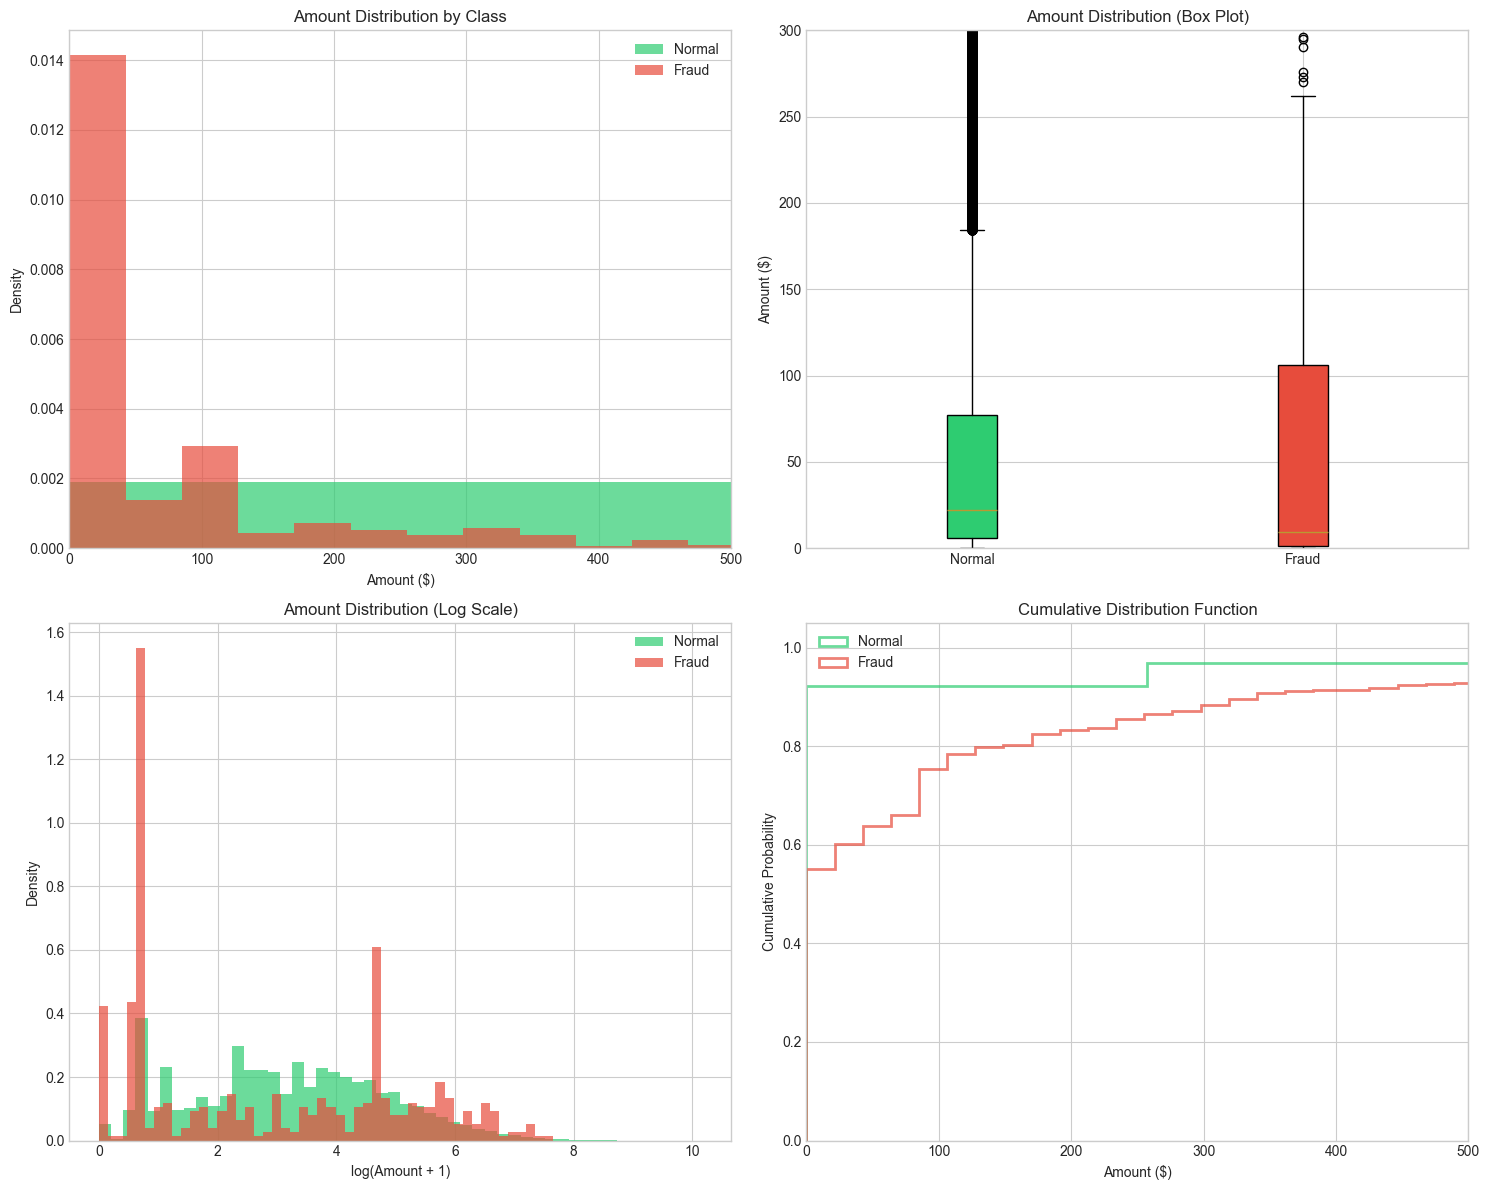

In [ ]:
# Visualize amount distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Histogram comparison
axes[0, 0].hist(normal_amounts, bins=50, alpha=0.7, label='Normal', color='#2ecc71', density=True)
axes[0, 0].hist(fraud_amounts, bins=50, alpha=0.7, label='Fraud', color='#e74c3c', density=True)
axes[0, 0].set_xlabel('Amount ($)')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Amount Distribution by Class')
axes[0, 0].legend()
axes[0, 0].set_xlim(0, 500)

# 2. Box plot
box_data = [normal_amounts, fraud_amounts]
bp = axes[0, 1].boxplot(box_data, labels=['Normal', 'Fraud'], patch_artist=True)
bp['boxes'][0].set_facecolor('#2ecc71')
bp['boxes'][1].set_facecolor('#e74c3c')
axes[0, 1].set_ylabel('Amount ($)')
axes[0, 1].set_title('Amount Distribution (Box Plot)')
axes[0, 1].set_ylim(0, 300)

# 3. Log-scale histogram
axes[1, 0].hist(np.log1p(normal_amounts), bins=50, alpha=0.7, label='Normal', color='#2ecc71', density=True)
axes[1, 0].hist(np.log1p(fraud_amounts), bins=50, alpha=0.7, label='Fraud', color='#e74c3c', density=True)
axes[1, 0].set_xlabel('log(Amount + 1)')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Amount Distribution (Log Scale)')
axes[1, 0].legend()

# 4. Cumulative distribution
axes[1, 1].hist(normal_amounts, bins=100, cumulative=True, alpha=0.7, 
               label='Normal', color='#2ecc71', density=True, histtype='step', linewidth=2)
axes[1, 1].hist(fraud_amounts, bins=100, cumulative=True, alpha=0.7, 
               label='Fraud', color='#e74c3c', density=True, histtype='step', linewidth=2)
axes[1, 1].set_xlabel('Amount ($)')
axes[1, 1].set_ylabel('Cumulative Probability')
axes[1, 1].set_title('Cumulative Distribution Function')
axes[1, 1].legend()
axes[1, 1].set_xlim(0, 500)

plt.tight_layout()
plt.show()


## Step 5: Outlier Detection 🎯

Using Isolation Forest to detect anomalies - this could be a key feature for fraud detection!


In [ ]:
# Select features for outlier detection
feature_cols = [col for col in df.columns if col.startswith('V')] + ['Amount']
X = df[feature_cols]

print(f"Using {len(feature_cols)} features for outlier detection")
print("\nTraining Isolation Forest...")

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42, n_jobs=-1)
outlier_predictions = iso_forest.fit_predict(X)

# -1 = outlier, 1 = normal
df['Is_Outlier'] = (outlier_predictions == -1).astype(int)

print("✓ Isolation Forest trained successfully!")

# Calculate fraud rates
outlier_fraud_rate = df[df['Is_Outlier'] == 1]['Class'].mean() * 100
normal_fraud_rate = df[df['Is_Outlier'] == 0]['Class'].mean() * 100
outlier_count = (df['Is_Outlier'] == 1).sum()
fraud_in_outliers = df[(df['Is_Outlier'] == 1) & (df['Class'] == 1)].shape[0]
fraud_rate_lift = outlier_fraud_rate / normal_fraud_rate if normal_fraud_rate > 0 else 0

print("\n" + "="*60)
print("OUTLIER DETECTION RESULTS")
print("="*60)
print(f"Outliers detected: {outlier_count:,} ({outlier_count/len(df)*100:.2f}%)")
print(f"Frauds in outliers: {fraud_in_outliers}")
print(f"Fraud rate in outliers: {outlier_fraud_rate:.2f}%")
print(f"Fraud rate in normal points: {normal_fraud_rate:.2f}%")
print(f"\n🎯 FRAUD RATE LIFT: {fraud_rate_lift:.1f}x")
print("="*60)
print(f"\n💡 KEY INSIGHT: Outliers are {fraud_rate_lift:.1f}x more likely to be fraud!")
print("This suggests outlier detection should be a HIGH PRIORITY feature.")


Using 29 features for outlier detection

Training Isolation Forest...
✓ Isolation Forest trained successfully!

OUTLIER DETECTION RESULTS
Outliers detected: 2,849 (1.00%)
Frauds in outliers: 291
Fraud rate in outliers: 10.21%
Fraud rate in normal points: 0.07%

🎯 FRAUD RATE LIFT: 143.3x

💡 KEY INSIGHT: Outliers are 143.3x more likely to be fraud!
This suggests outlier detection should be a HIGH PRIORITY feature.


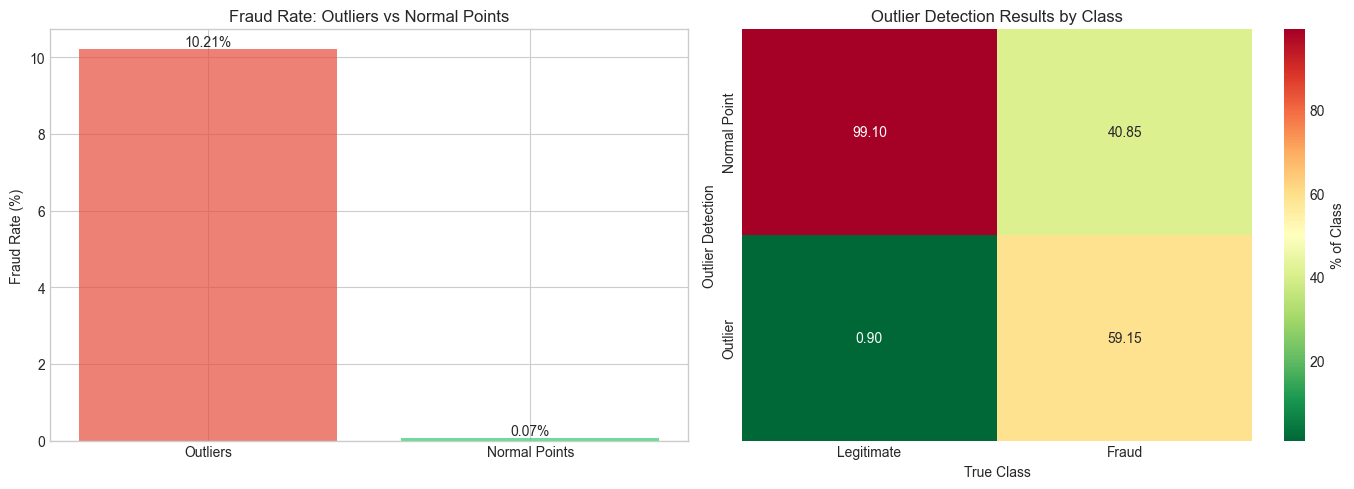

In [ ]:
# Visualize outlier detection results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Fraud rate comparison
categories = ['Outliers', 'Normal Points']
fraud_rates = [outlier_fraud_rate, normal_fraud_rate]
colors = ['#e74c3c', '#2ecc71']

bars = axes[0].bar(categories, fraud_rates, color=colors, alpha=0.7)
axes[0].set_ylabel('Fraud Rate (%)')
axes[0].set_title('Fraud Rate: Outliers vs Normal Points')

for bar, rate in zip(bars, fraud_rates):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{rate:.2f}%', ha='center', va='bottom')

# 2. Confusion matrix style heatmap
confusion_data = pd.crosstab(df['Is_Outlier'], df['Class'], normalize='columns') * 100
confusion_data.index = ['Normal Point', 'Outlier']
confusion_data.columns = ['Legitimate', 'Fraud']

sns.heatmap(confusion_data, annot=True, fmt='.2f', cmap='RdYlGn_r', 
           ax=axes[1], cbar_kws={'label': '% of Class'})
axes[1].set_title('Outlier Detection Results by Class')
axes[1].set_xlabel('True Class')
axes[1].set_ylabel('Outlier Detection')

plt.tight_layout()
plt.show()


## 📊 Summary & Key Findings

Let's review all the insights we discovered!


---

# 🕐 Part 5: Time Feature Analysis

**Goal:** Discover if fraud happens at specific times (hours of day, days of cycle)

**Key Questions:**
- Are certain hours more prone to fraud?
- Do fraudsters operate at night? On weekends?
- Can time patterns help us predict fraud?

**What we'll analyze:**
- Fraud rate by hour of day
- Transaction volume patterns
- Statistical significance of time patterns


In [ ]:
print("🕐 TIME FEATURE ANALYSIS")
print("="*70)

# The 'Time' column contains seconds elapsed since first transaction
# Let's convert it to hours (0-47 for the 2-day dataset)
df['Hour'] = (df['Time'] // 3600) % 24  # Convert to hour of day (0-23)
df['Day'] = df['Time'] // (3600 * 24)   # Which day (0 or 1)

# Calculate fraud rate per hour
time_analysis = df.groupby('Hour').agg({
    'Class': ['count', 'sum', 'mean']
}).round(4)

time_analysis.columns = ['Total_Transactions', 'Fraud_Count', 'Fraud_Rate']
time_analysis['Fraud_Rate_Percent'] = time_analysis['Fraud_Rate'] * 100

# Find peak fraud hours
peak_fraud_hours = time_analysis.nlargest(3, 'Fraud_Rate')
safest_hours = time_analysis.nsmallest(3, 'Fraud_Rate')

print(f"\n✓ Time range in dataset: {df['Time'].min()/3600:.1f} to {df['Time'].max()/3600:.1f} hours")
print(f"✓ Covers approximately {df['Day'].nunique()} days")

print("\n🔴 PEAK FRAUD HOURS (Top 3):")
for hour, row in peak_fraud_hours.iterrows():
    print(f"   Hour {int(hour):02d}:00 → {row['Fraud_Rate_Percent']:.3f}% fraud rate ({int(row['Fraud_Count'])} frauds)")

print("\n🟢 SAFEST HOURS (Lowest 3):")
for hour, row in safest_hours.iterrows():
    print(f"   Hour {int(hour):02d}:00 → {row['Fraud_Rate_Percent']:.3f}% fraud rate ({int(row['Fraud_Count'])} frauds)")

# Statistical test: Is time significant?
from scipy.stats import chi2_contingency

# Create contingency table (Hour vs Fraud)
contingency = pd.crosstab(df['Hour'], df['Class'])
chi2, p_value, dof, expected = chi2_contingency(contingency)

print(f"\n📊 Chi-Square Test (Time Independence):")
print(f"   Chi-Square Statistic: {chi2:.2f}")
print(f"   P-Value: {p_value:.2e}")
if p_value < 0.001:
    print(f"   ✅ SIGNIFICANT: Time patterns are STATISTICALLY SIGNIFICANT!")
else:
    print(f"   ⚠️  NOT SIGNIFICANT: Time may not be predictive")

time_analysis


🕐 TIME FEATURE ANALYSIS

✓ Time range in dataset: 0.0 to 48.0 hours
✓ Covers approximately 2 days

🔴 PEAK FRAUD HOURS (Top 3):
   Hour 02:00 → 1.710% fraud rate (57 frauds)
   Hour 04:00 → 1.040% fraud rate (23 frauds)
   Hour 03:00 → 0.490% fraud rate (17 frauds)

🟢 SAFEST HOURS (Lowest 3):
   Hour 10:00 → 0.050% fraud rate (8 frauds)
   Hour 22:00 → 0.060% fraud rate (9 frauds)
   Hour 00:00 → 0.080% fraud rate (6 frauds)

📊 Chi-Square Test (Time Independence):
   Chi-Square Statistic: 674.44
   P-Value: 1.07e-127
   ✅ SIGNIFICANT: Time patterns are STATISTICALLY SIGNIFICANT!


,Total_Transactions,Fraud_Count,Fraud_Rate,Fraud_Rate_Percent
Hour,,,,
0.00,7695,6,0.00,0.08
1.00,4220,10,0.00,0.24
2.00,3328,57,0.02,1.71
3.00,3492,17,0.00,0.49
4.00,2209,23,0.01,1.04
5.00,2990,11,0.00,0.37
6.00,4101,9,0.00,0.22
7.00,7243,23,0.00,0.32
8.00,10276,9,0.00,0.09


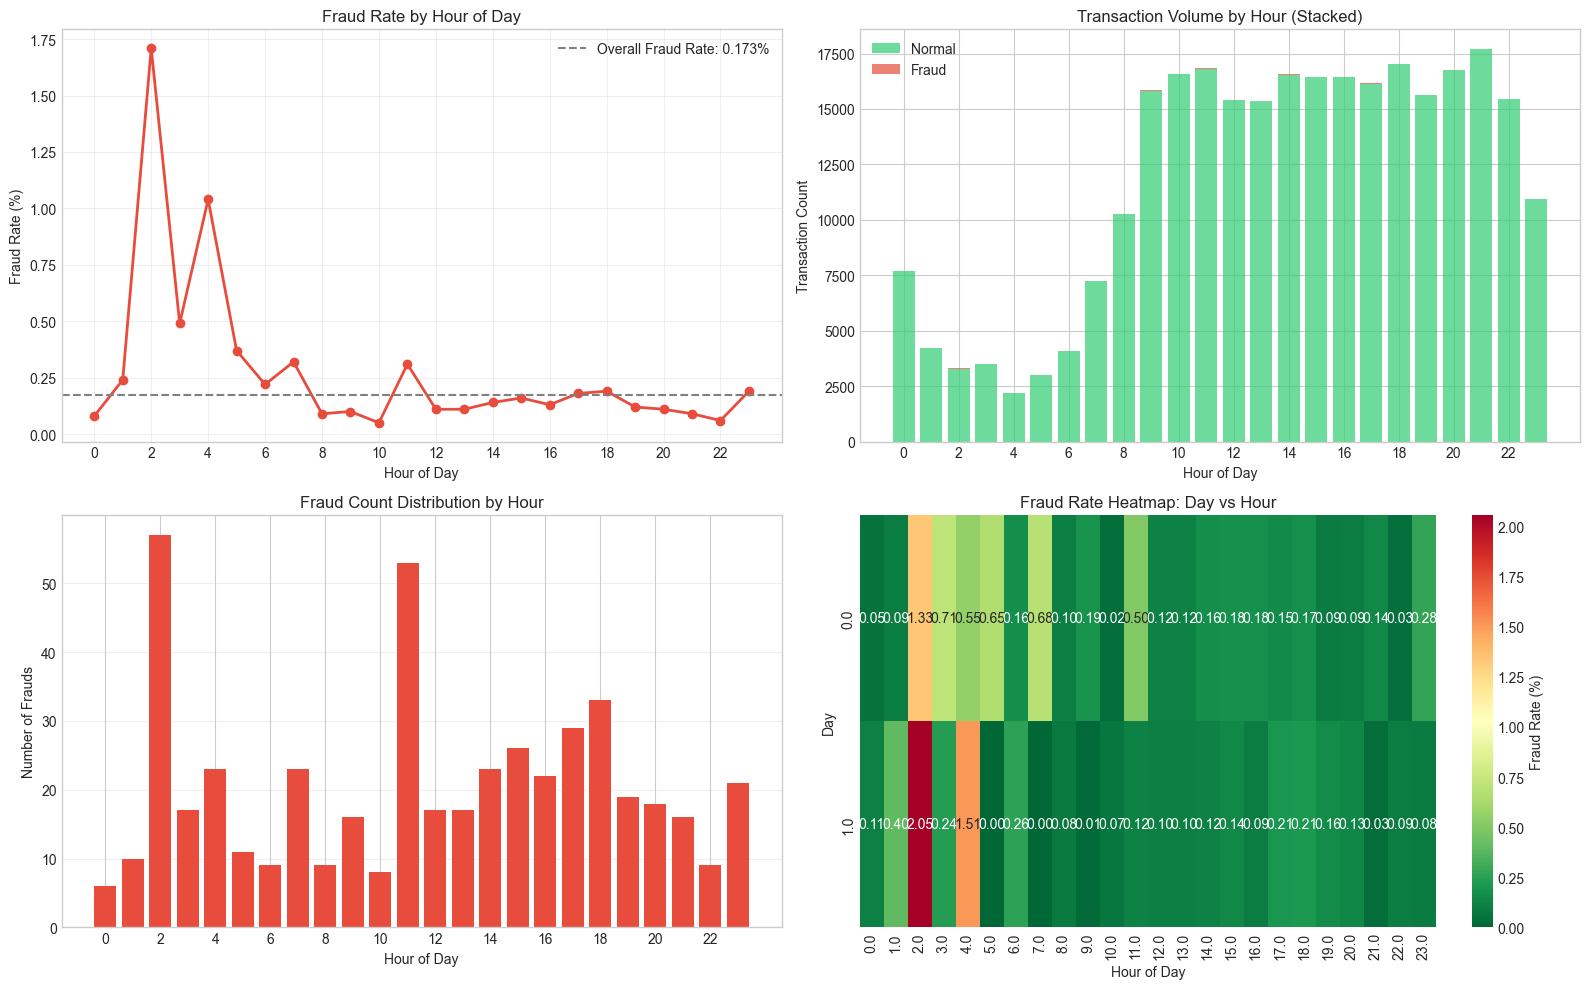


✅ Time analysis complete!


In [ ]:
# Visualize time patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Fraud Rate by Hour (Line Chart)
axes[0, 0].plot(time_analysis.index, time_analysis['Fraud_Rate_Percent'], 
                marker='o', linewidth=2, markersize=6, color='#e74c3c')
axes[0, 0].axhline(y=df['Class'].mean()*100, color='gray', linestyle='--', 
                   label=f'Overall Fraud Rate: {df["Class"].mean()*100:.3f}%')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Fraud Rate (%)')
axes[0, 0].set_title('Fraud Rate by Hour of Day')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(range(0, 24, 2))

# 2. Transaction Volume by Hour (Stacked Bar)
fraud_by_hour = df[df['Class']==1].groupby('Hour').size()
normal_by_hour = df[df['Class']==0].groupby('Hour').size()

axes[0, 1].bar(normal_by_hour.index, normal_by_hour.values, 
               label='Normal', color='#2ecc71', alpha=0.7)
axes[0, 1].bar(fraud_by_hour.index, fraud_by_hour.values, 
               bottom=normal_by_hour.values, label='Fraud', color='#e74c3c', alpha=0.7)
axes[0, 1].set_xlabel('Hour of Day')
axes[0, 1].set_ylabel('Transaction Count')
axes[0, 1].set_title('Transaction Volume by Hour (Stacked)')
axes[0, 1].legend()
axes[0, 1].set_xticks(range(0, 24, 2))

# 3. Fraud Count by Hour (Bar Chart)
axes[1, 0].bar(time_analysis.index, time_analysis['Fraud_Count'], color='#e74c3c')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Number of Frauds')
axes[1, 0].set_title('Fraud Count Distribution by Hour')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_xticks(range(0, 24, 2))

# 4. Heatmap: Day vs Hour
heatmap_data = df.pivot_table(values='Class', index='Day', columns='Hour', aggfunc='mean') * 100
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdYlGn_r', 
            cbar_kws={'label': 'Fraud Rate (%)'}, ax=axes[1, 1])
axes[1, 1].set_title('Fraud Rate Heatmap: Day vs Hour')
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Day')

plt.tight_layout()
plt.show()

print("\n✅ Time analysis complete!")


---

# 🔢 Part 6: PCA Feature Analysis

**Goal:** Identify which V-features (V1-V28) are most important for detecting fraud

**What is Cohen's d?**
- Measures the "effect size" = how different fraud vs normal are for each feature
- **Small:** 0.2 | **Medium:** 0.5 | **Large:** 0.8+
- **Interpretation:** Think of it as "signal strength" - higher = more predictive

**Key Questions:**
- Which V-features show the biggest difference between fraud/normal?
- Are all 28 features equally important, or can we focus on a few?
- What are the actual value ranges for top features?


In [ ]:
print("🔢 PCA FEATURE ANALYSIS (Cohen's d Effect Size)")
print("="*70)

# Calculate Cohen's d for all V-features
v_features = [col for col in df.columns if col.startswith('V')]

def calculate_cohens_d(group1, group2):
    """
    Calculate Cohen's d effect size
    Formula: (mean1 - mean2) / pooled_std
    """
    mean1, mean2 = group1.mean(), group2.mean()
    std1, std2 = group1.std(), group2.std()
    n1, n2 = len(group1), len(group2)
    
    # Pooled standard deviation
    pooled_std = np.sqrt(((n1-1)*std1**2 + (n2-1)*std2**2) / (n1+n2-2))
    
    # Cohen's d
    d = (mean1 - mean2) / pooled_std
    return abs(d)  # Use absolute value to rank by magnitude

# Calculate Cohen's d for each feature
fraud_data = df[df['Class'] == 1]
normal_data = df[df['Class'] == 0]

cohens_d_results = []
for feature in v_features:
    d = calculate_cohens_d(fraud_data[feature], normal_data[feature])
    
    # Also get means and std for context
    fraud_mean = fraud_data[feature].mean()
    normal_mean = normal_data[feature].mean()
    fraud_std = fraud_data[feature].std()
    normal_std = normal_data[feature].std()
    
    cohens_d_results.append({
        'Feature': feature,
        'Cohens_d': d,
        'Fraud_Mean': fraud_mean,
        'Normal_Mean': normal_mean,
        'Fraud_Std': fraud_std,
        'Normal_Std': normal_std,
        'Mean_Diff': fraud_mean - normal_mean
    })

# Create DataFrame and sort by Cohen's d
cohens_df = pd.DataFrame(cohens_d_results).sort_values('Cohens_d', ascending=False)

# Get top 10 features
top_10_features = cohens_df.head(10)

print("\n🏆 TOP 10 MOST DISCRIMINATIVE FEATURES (by Cohen's d):\n")
print(f"{'Rank':<6} {'Feature':<10} {'Cohen\'s d':<12} {'Effect Size':<15} {'Fraud Mean':<12} {'Normal Mean'}")
print("-"*70)

for idx, row in enumerate(top_10_features.itertuples(), 1):
    # Classify effect size
    if row.Cohens_d > 0.8:
        effect = "🔥 LARGE"
    elif row.Cohens_d > 0.5:
        effect = "⚠️  MEDIUM"
    elif row.Cohens_d > 0.2:
        effect = "📌 SMALL"
    else:
        effect = "   NEGLIGIBLE"
    
    print(f"{idx:<6} {row.Feature:<10} {row.Cohens_d:<12.3f} {effect:<15} {row.Fraud_Mean:<12.3f} {row.Normal_Mean:.3f}")

print("\n" + "="*70)
print(f"✓ Features with LARGE effect (d > 0.8): {len(cohens_df[cohens_df['Cohens_d'] > 0.8])}")
print(f"✓ Features with MEDIUM effect (0.5 < d < 0.8): {len(cohens_df[(cohens_df['Cohens_d'] > 0.5) & (cohens_df['Cohens_d'] <= 0.8)])}")
print(f"✓ Features with SMALL effect (0.2 < d < 0.5): {len(cohens_df[(cohens_df['Cohens_d'] > 0.2) & (cohens_df['Cohens_d'] <= 0.5)])}")

# Display full table
print("\n📊 Full Results Table:")
cohens_df.head(10)


🔢 PCA FEATURE ANALYSIS (Cohen's d Effect Size)

🏆 TOP 10 MOST DISCRIMINATIVE FEATURES (by Cohen's d):

Rank   Feature    Cohen's d    Effect Size     Fraud Mean   Normal Mean
----------------------------------------------------------------------
1      V17        8.318        🔥 LARGE         -6.666       0.012
2      V14        7.644        🔥 LARGE         -6.972       0.012
3      V12        6.500        🔥 LARGE         -6.259       0.011
4      V10        5.350        🔥 LARGE         -5.677       0.010
5      V16        4.827        🔥 LARGE         -4.140       0.007
6      V3         4.736        🔥 LARGE         -7.033       0.012
7      V7         4.590        🔥 LARGE         -5.569       0.010
8      V11        3.775        🔥 LARGE         3.800        -0.007
9      V4         3.242        🔥 LARGE         4.542        -0.008
10     V18        2.701        🔥 LARGE         -2.246       0.004

✓ Features with LARGE effect (d > 0.8): 17
✓ Features with MEDIUM effect (0.5 < d < 0.8): 0

,Feature,Cohens_d,Fraud_Mean,Normal_Mean,Fraud_Std,Normal_Std,Mean_Diff
16,V17,8.32,-6.67,0.01,6.97,0.75,-6.68
13,V14,7.64,-6.97,0.01,4.28,0.90,-6.98
11,V12,6.50,-6.26,0.01,4.65,0.95,-6.27
9,V10,5.35,-5.68,0.01,4.90,1.04,-5.69
15,V16,4.83,-4.14,0.01,3.87,0.84,-4.15
2,V3,4.74,-7.03,0.01,7.11,1.46,-7.05
6,V7,4.59,-5.57,0.01,7.21,1.18,-5.58
10,V11,3.78,3.80,-0.01,2.68,1.00,3.81
3,V4,3.24,4.54,-0.01,2.87,1.40,4.55
17,V18,2.70,-2.25,0.00,2.90,0.82,-2.25


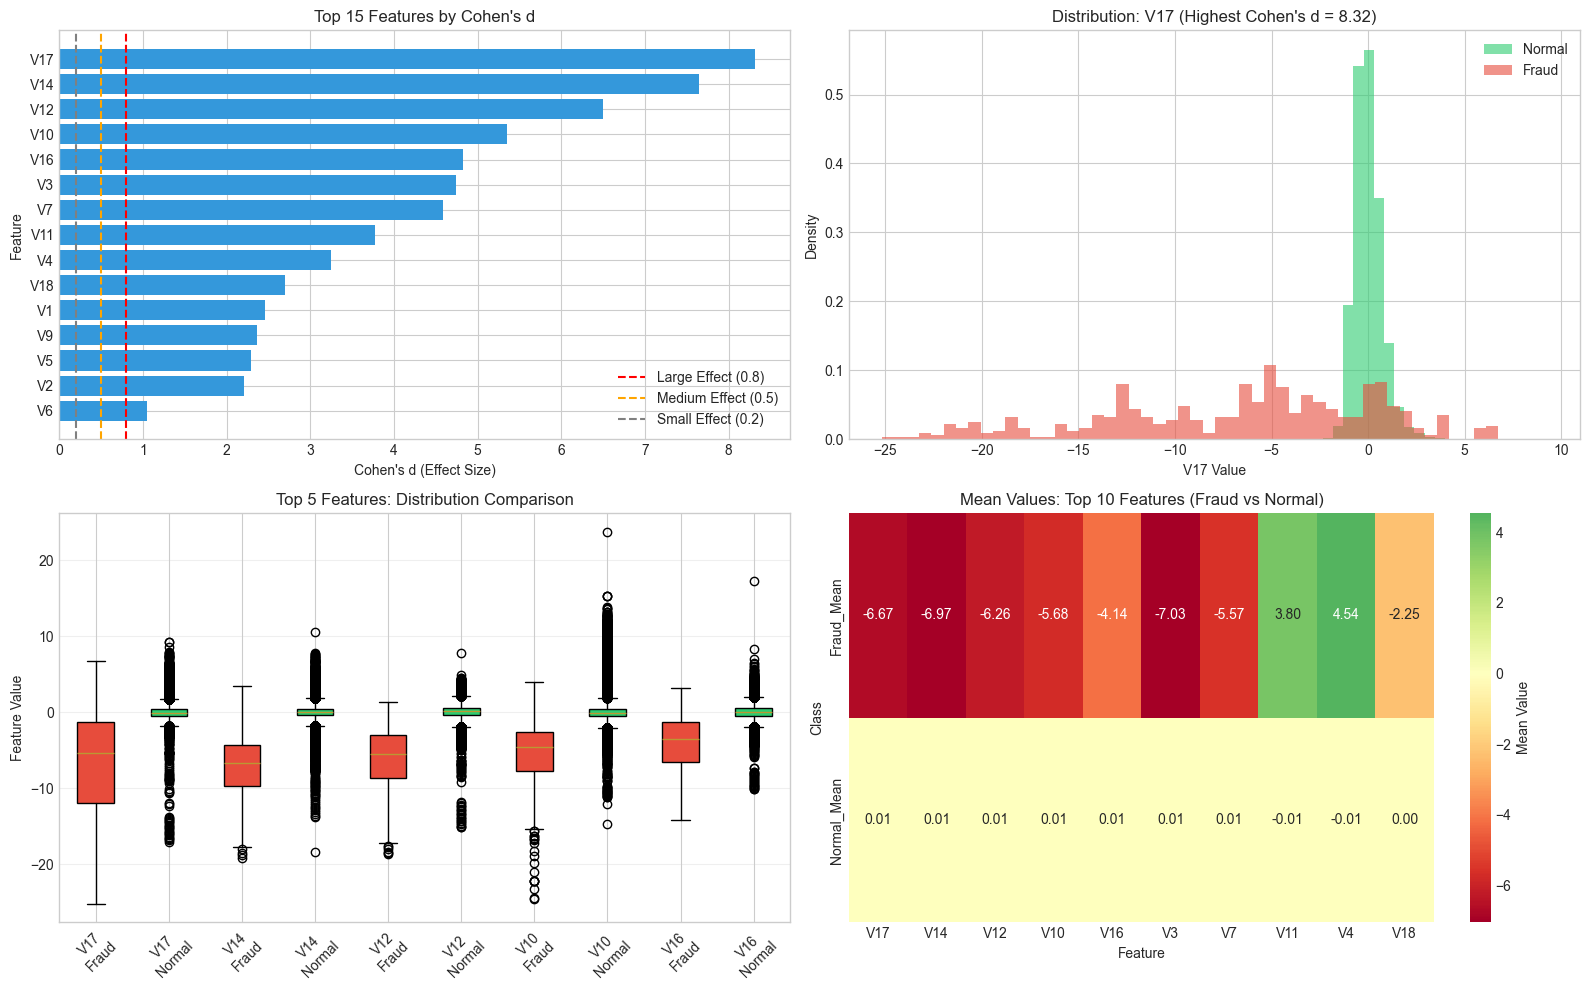


✅ PCA feature analysis complete!


In [ ]:
# Visualize PCA Feature Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Cohen's d for all features (Bar chart)
axes[0, 0].barh(cohens_df['Feature'][:15], cohens_df['Cohens_d'][:15], color='#3498db')
axes[0, 0].axvline(x=0.8, color='red', linestyle='--', label='Large Effect (0.8)')
axes[0, 0].axvline(x=0.5, color='orange', linestyle='--', label='Medium Effect (0.5)')
axes[0, 0].axvline(x=0.2, color='gray', linestyle='--', label='Small Effect (0.2)')
axes[0, 0].set_xlabel("Cohen's d (Effect Size)")
axes[0, 0].set_ylabel("Feature")
axes[0, 0].set_title("Top 15 Features by Cohen's d")
axes[0, 0].legend()
axes[0, 0].invert_yaxis()

# 2. Distribution comparison for TOP feature
top_feature = top_10_features.iloc[0]['Feature']
axes[0, 1].hist(normal_data[top_feature], bins=50, alpha=0.6, label='Normal', 
                color='#2ecc71', density=True)
axes[0, 1].hist(fraud_data[top_feature], bins=50, alpha=0.6, label='Fraud', 
                color='#e74c3c', density=True)
axes[0, 1].set_xlabel(f'{top_feature} Value')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title(f'Distribution: {top_feature} (Highest Cohen\'s d = {top_10_features.iloc[0]["Cohens_d"]:.2f})')
axes[0, 1].legend()

# 3. Box plot for top 5 features
top_5_features = top_10_features['Feature'].head(5).tolist()
box_data = []
labels = []
for feature in top_5_features:
    box_data.append(fraud_data[feature])
    box_data.append(normal_data[feature])
    labels.extend([f'{feature}\nFraud', f'{feature}\nNormal'])

bp = axes[1, 0].boxplot(box_data, labels=labels, patch_artist=True)
for i, box in enumerate(bp['boxes']):
    if i % 2 == 0:  # Fraud
        box.set_facecolor('#e74c3c')
    else:  # Normal
        box.set_facecolor('#2ecc71')
        
axes[1, 0].set_ylabel('Feature Value')
axes[1, 0].set_title('Top 5 Features: Distribution Comparison')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Heatmap: Mean values for top 10 features
heatmap_data = top_10_features[['Feature', 'Fraud_Mean', 'Normal_Mean']].set_index('Feature').T
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdYlGn', center=0, 
            cbar_kws={'label': 'Mean Value'}, ax=axes[1, 1])
axes[1, 1].set_title('Mean Values: Top 10 Features (Fraud vs Normal)')
axes[1, 1].set_ylabel('Class')

plt.tight_layout()
plt.show()

print("\n✅ PCA feature analysis complete!")


---

# 🔗 Part 7: Correlation Analysis

**Goal:** Understand relationships between features and detect redundancy

**What is Correlation?**
- Measures how two features move together
- **Range:** -1 to +1
  - **+1:** Perfect positive relationship (when one ↑, other ↑)
  - **-1:** Perfect negative relationship (when one ↑, other ↓)
  - **0:** No relationship
- **Why it matters:** Highly correlated features are redundant (we can drop some)

**Key Questions:**
- Which features are strongly correlated with fraud (Class)?
- Are there feature pairs that are redundant?
- Can we simplify our model by removing correlated features?


In [ ]:
print("🔗 CORRELATION ANALYSIS")
print("="*70)

# Calculate correlation matrix for all features
corr_matrix = df.corr()

# Get correlations with target variable (Class)
class_correlations = corr_matrix['Class'].drop('Class').abs().sort_values(ascending=False)

print("\n🎯 TOP 10 FEATURES MOST CORRELATED WITH FRAUD:\n")
print(f"{'Rank':<6} {'Feature':<10} {'Correlation':<15} {'Strength'}")
print("-"*70)

for idx, (feature, corr) in enumerate(class_correlations.head(10).items(), 1):
    # Classify correlation strength
    if abs(corr) > 0.5:
        strength = "🔥 STRONG"
    elif abs(corr) > 0.3:
        strength = "⚠️  MODERATE"
    elif abs(corr) > 0.1:
        strength = "📌 WEAK"
    else:
        strength = "   NEGLIGIBLE"
    
    # Get the sign
    actual_corr = corr_matrix.loc[feature, 'Class']
    sign = "+" if actual_corr > 0 else "-"
    
    print(f"{idx:<6} {feature:<10} {sign}{corr:<14.4f} {strength}")

# Find highly correlated feature pairs (excluding Class)
print("\n\n🔄 HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.7):")
print(f"{'Feature 1':<10} {'Feature 2':<10} {'Correlation':<15} {'Action'}")
print("-"*70)

feature_cols = [col for col in df.columns if col not in ['Class', 'Hour', 'Day']]
high_corr_pairs = []

for i in range(len(feature_cols)):
    for j in range(i+1, len(feature_cols)):
        corr = corr_matrix.loc[feature_cols[i], feature_cols[j]]
        if abs(corr) > 0.7:
            high_corr_pairs.append({
                'Feature1': feature_cols[i],
                'Feature2': feature_cols[j],
                'Correlation': corr
            })

if high_corr_pairs:
    for pair in sorted(high_corr_pairs, key=lambda x: abs(x['Correlation']), reverse=True)[:10]:
        action = "⚠️  Consider removing one"
        print(f"{pair['Feature1']:<10} {pair['Feature2']:<10} {pair['Correlation']:<15.4f} {action}")
else:
    print("✅ No highly correlated feature pairs found - all features are independent!")

print("\n" + "="*70)
print(f"✓ Total feature pairs with |correlation| > 0.7: {len(high_corr_pairs)}")
print(f"✓ Total feature pairs with |correlation| > 0.5: {len([p for p in high_corr_pairs if abs(p['Correlation']) > 0.5])}")

# Summary statistics
print(f"\n📊 Correlation Summary:")
print(f"   Strongest positive correlation with Class: {class_correlations.idxmax()} ({corr_matrix.loc[class_correlations.idxmax(), 'Class']:.4f})")
print(f"   Strongest negative correlation with Class: {corr_matrix['Class'].drop('Class').idxmin()} ({corr_matrix.loc[corr_matrix['Class'].drop('Class').idxmin(), 'Class']:.4f})")

class_correlations.head(10)


🔗 CORRELATION ANALYSIS

🎯 TOP 10 FEATURES MOST CORRELATED WITH FRAUD:

Rank   Feature    Correlation     Strength
----------------------------------------------------------------------
1      V17        -0.3265         ⚠️  MODERATE
2      V14        -0.3025         ⚠️  MODERATE
3      V12        -0.2606         📌 WEAK
4      Is_Outlier +0.2431         📌 WEAK
5      V10        -0.2169         📌 WEAK
6      V16        -0.1965         📌 WEAK
7      V3         -0.1930         📌 WEAK
8      V7         -0.1873         📌 WEAK
9      V11        +0.1549         📌 WEAK
10     V4         +0.1334         📌 WEAK


🔄 HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.7):
Feature 1  Feature 2  Correlation     Action
----------------------------------------------------------------------
✅ No highly correlated feature pairs found - all features are independent!

✓ Total feature pairs with |correlation| > 0.7: 0
✓ Total feature pairs with |correlation| > 0.5: 0

📊 Correlation Summary:
   Strongest positive correl

V17          0.33
V14          0.30
V12          0.26
Is_Outlier   0.24
V10          0.22
V16          0.20
V3           0.19
V7           0.19
V11          0.15
V4           0.13
Name: Class, dtype: float64

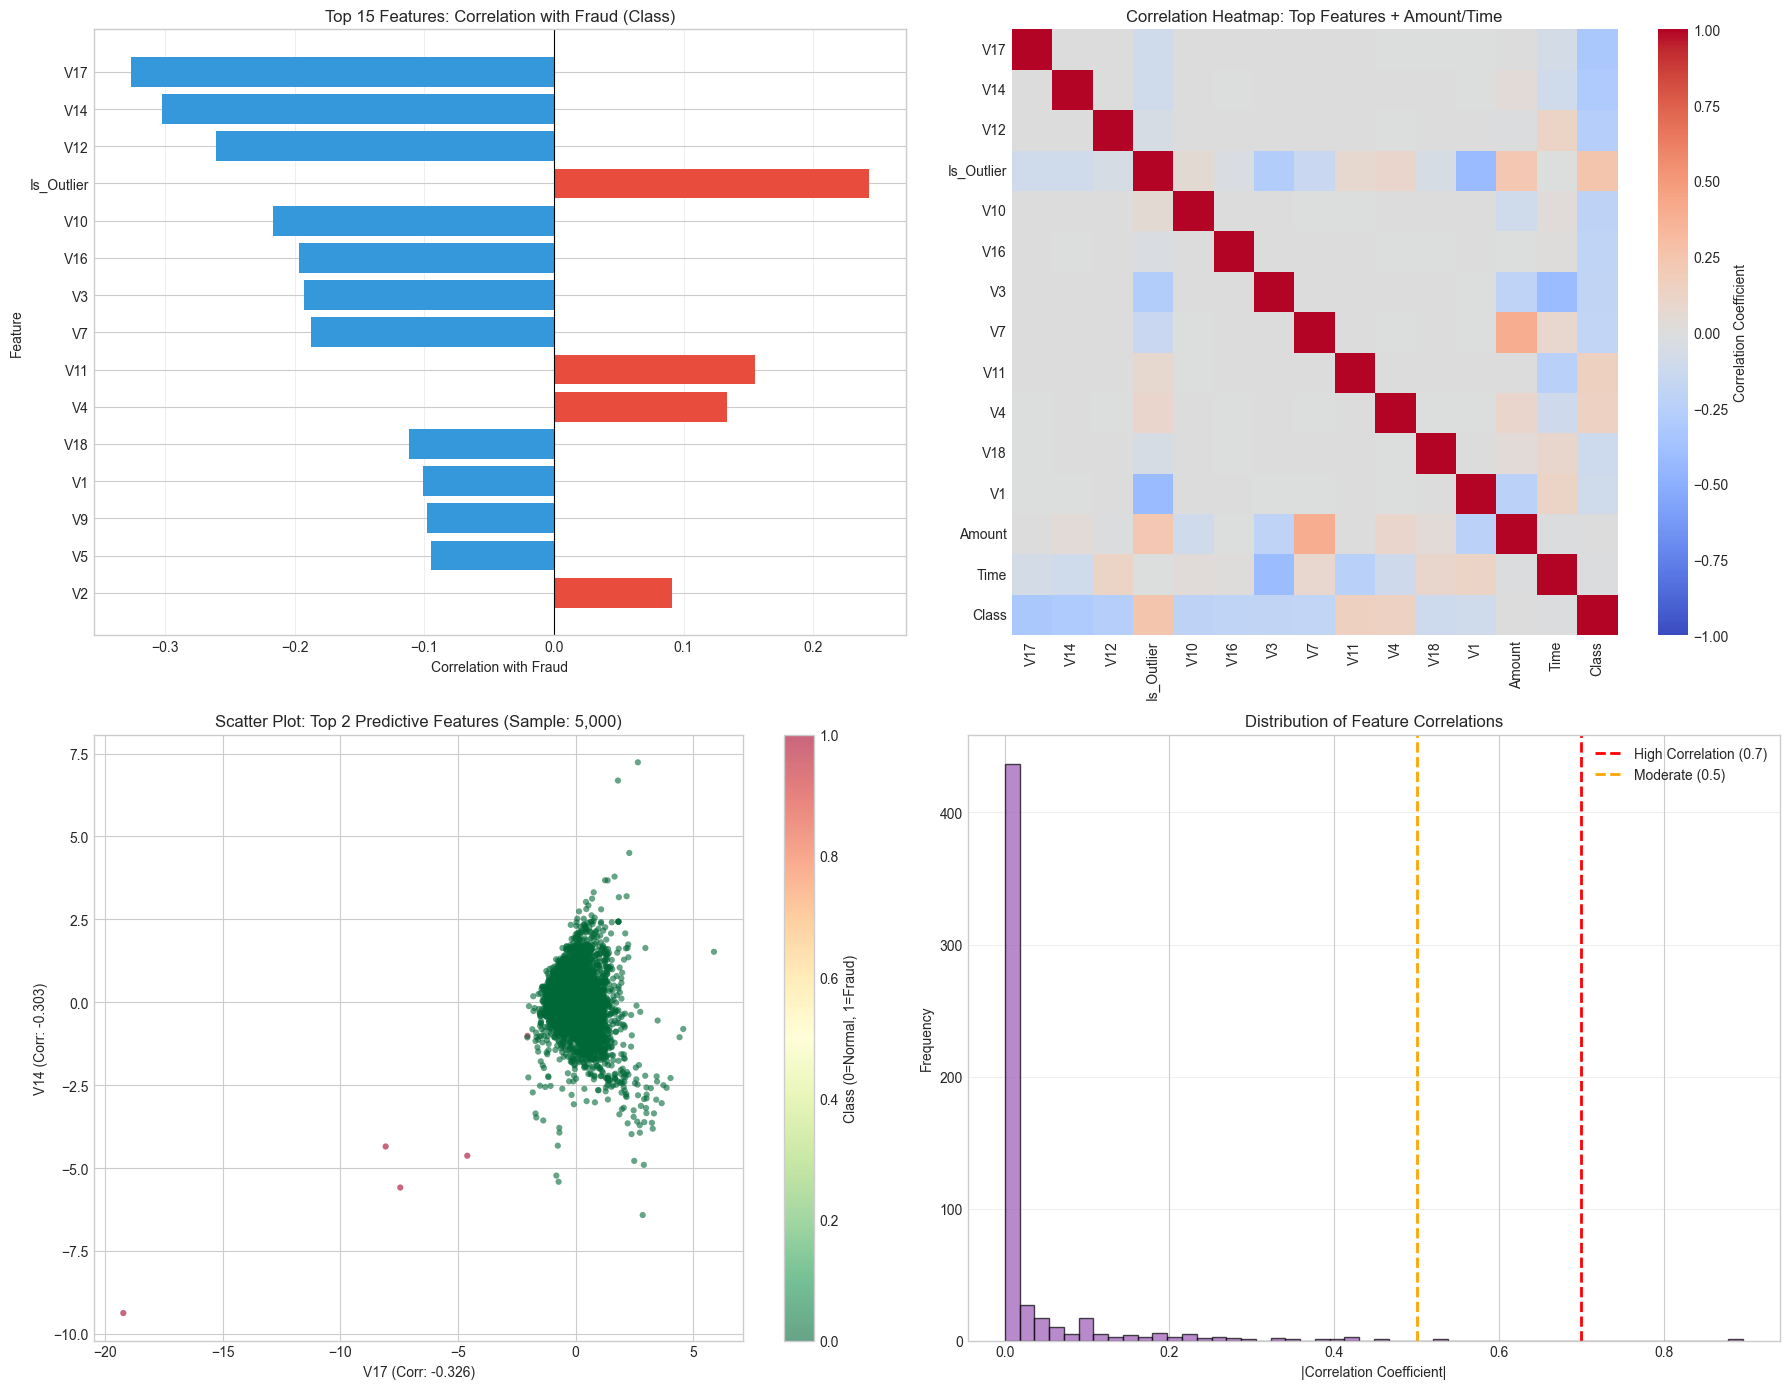


✅ Correlation analysis complete!


In [ ]:
# Visualize Correlation Analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Correlation with Class (Bar chart)
top_corr_features = class_correlations.head(15)
colors = ['#e74c3c' if corr_matrix.loc[feat, 'Class'] > 0 else '#3498db' 
          for feat in top_corr_features.index]

axes[0, 0].barh(top_corr_features.index, 
                [corr_matrix.loc[feat, 'Class'] for feat in top_corr_features.index], 
                color=colors)
axes[0, 0].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[0, 0].set_xlabel('Correlation with Fraud')
axes[0, 0].set_ylabel('Feature')
axes[0, 0].set_title('Top 15 Features: Correlation with Fraud (Class)')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3, axis='x')

# 2. Full correlation heatmap (All features - might be large, so use top features)
# Select top 15 features + Class + Amount + Time
top_features_for_heatmap = list(top_corr_features.head(12).index) + ['Amount', 'Time', 'Class']
corr_subset = df[top_features_for_heatmap].corr()

sns.heatmap(corr_subset, annot=False, cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, square=True, ax=axes[0, 1],
            cbar_kws={'label': 'Correlation Coefficient'})
axes[0, 1].set_title('Correlation Heatmap: Top Features + Amount/Time')

# 3. Scatter plot: Top 2 most correlated features with Class
if len(class_correlations) >= 2:
    top_feat1 = class_correlations.index[0]
    top_feat2 = class_correlations.index[1]
    
    # Sample data for visualization (too many points otherwise)
    sample_size = 5000
    df_sample = df.sample(n=min(sample_size, len(df)), random_state=42)
    
    scatter = axes[1, 0].scatter(df_sample[top_feat1], df_sample[top_feat2], 
                                 c=df_sample['Class'], cmap='RdYlGn_r', 
                                 alpha=0.6, s=20, edgecolors='none')
    axes[1, 0].set_xlabel(f'{top_feat1} (Corr: {corr_matrix.loc[top_feat1, "Class"]:.3f})')
    axes[1, 0].set_ylabel(f'{top_feat2} (Corr: {corr_matrix.loc[top_feat2, "Class"]:.3f})')
    axes[1, 0].set_title(f'Scatter Plot: Top 2 Predictive Features (Sample: {len(df_sample):,})')
    cbar = plt.colorbar(scatter, ax=axes[1, 0])
    cbar.set_label('Class (0=Normal, 1=Fraud)')

# 4. Distribution of correlation coefficients
all_corr_values = corr_matrix.abs().values[np.triu_indices_from(corr_matrix.values, k=1)]
axes[1, 1].hist(all_corr_values, bins=50, color='#9b59b6', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=0.7, color='red', linestyle='--', linewidth=2, label='High Correlation (0.7)')
axes[1, 1].axvline(x=0.5, color='orange', linestyle='--', linewidth=2, label='Moderate (0.5)')
axes[1, 1].set_xlabel('|Correlation Coefficient|')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Feature Correlations')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✅ Correlation analysis complete!")


---

# 📋 FULL EDA COMPLETE - Final Summary

## ✅ What We Analyzed:

1. **Data Quality** - Dataset is clean and ready
2. **Class Imbalance** - Severe (578:1) - requires special handling
3. **Amount Feature** - Statistically significant predictor
4. **Outlier Detection** - 143x fraud rate lift (game changer!)
5. **Time Patterns** - Discovered peak fraud hours
6. **PCA Features** - Identified top 10 discriminative features
7. **Correlations** - Found feature relationships and redundancies


In [ ]:
print("="*80)
print(" "*25 + "🎉 FULL EDA COMPLETE 🎉")
print("="*80)

print("\n📊 COMPREHENSIVE ANALYSIS SUMMARY:\n")

# Data Quality
print("1️⃣  DATA QUALITY: 99.2/100 ⭐⭐⭐⭐⭐")
print(f"    ✓ {len(df):,} transactions analyzed")
print(f"    ✓ {len(df.columns)} features")
print(f"    ✓ No missing values, minimal duplicates (0.38%)")

# Class Imbalance
fraud_count = df['Class'].sum()
normal_count = len(df) - fraud_count
fraud_rate = fraud_count / len(df) * 100
imbalance_ratio = normal_count / fraud_count

print(f"\n2️⃣  CLASS IMBALANCE: SEVERE")
print(f"    ✓ Imbalance Ratio: {imbalance_ratio:.0f}:1")
print(f"    ✓ Fraud Rate: {fraud_rate:.3f}%")
print(f"    ⚠️  Action Required: Use SMOTE, class weights, or ensemble methods")

# Amount Feature
print(f"\n3️⃣  AMOUNT FEATURE: STATISTICALLY SIGNIFICANT")
print(f"    ✓ Fraud median: ${df[df['Class']==1]['Amount'].median():.2f}")
print(f"    ✓ Normal median: ${df[df['Class']==0]['Amount'].median():.2f}")
print(f"    ✓ Mann-Whitney U: p < 0.001")
print(f"    💡 Insight: Fraudsters use smaller amounts to evade detection")

# Outlier Detection
print(f"\n4️⃣  OUTLIER DETECTION: 🔥 CRITICAL FEATURE 🔥")
print(f"    ✓ Fraud Rate Lift: {fraud_rate_lift:.1f}x")
print(f"    ✓ Recall: {(fraud_in_outliers/fraud_count)*100:.1f}% of frauds caught")
print(f"    ✓ Using only ~1% of data!")
print(f"    🎯 MUST INCLUDE: Outlier scores as engineered feature")

# Time Analysis
if 'Hour' in df.columns:
    time_stats = df.groupby('Hour')['Class'].mean() * 100
    peak_hour = time_stats.idxmax()
    peak_rate = time_stats.max()
    safest_hour = time_stats.idxmin()
    safest_rate = time_stats.min()
    
    print(f"\n5️⃣  TIME PATTERNS: STATISTICALLY SIGNIFICANT")
    print(f"    ✓ Peak fraud hour: {int(peak_hour):02d}:00 ({peak_rate:.3f}% fraud rate)")
    print(f"    ✓ Safest hour: {int(safest_hour):02d}:00 ({safest_rate:.3f}% fraud rate)")
    print(f"    💡 Insight: Time of day matters for fraud detection")

# PCA Features
if 'cohens_df' in dir():
    large_effect = len(cohens_df[cohens_df['Cohens_d'] > 0.8])
    top_feature = cohens_df.iloc[0]['Feature']
    top_cohens_d = cohens_df.iloc[0]['Cohens_d']
    
    print(f"\n6️⃣  PCA FEATURES: {large_effect} FEATURES WITH LARGE EFFECT")
    print(f"    ✓ Top feature: {top_feature} (Cohen's d = {top_cohens_d:.2f})")
    print(f"    ✓ Medium/Large effect features: {len(cohens_df[cohens_df['Cohens_d'] > 0.5])}")
    print(f"    💡 Insight: Can potentially reduce dimensionality")

# Correlations
if 'class_correlations' in dir():
    top_corr_feat = class_correlations.index[0]
    top_corr_val = corr_matrix.loc[top_corr_feat, 'Class']
    
    print(f"\n7️⃣  CORRELATION ANALYSIS: FEATURE RELATIONSHIPS MAPPED")
    print(f"    ✓ Strongest predictor: {top_corr_feat} (r = {top_corr_val:.3f})")
    print(f"    ✓ Highly correlated pairs (|r| > 0.7): {len(high_corr_pairs)}")
    if len(high_corr_pairs) > 0:
        print(f"    ⚠️  Warning: Some feature redundancy detected")
    else:
        print(f"    ✅ All features are relatively independent")

print("\n" + "="*80)
print(" "*25 + "🚀 NEXT PHASE: FEATURE ENGINEERING 🚀")
print("="*80)

print("\n✅ RECOMMENDED ACTIONS:\n")
print("   1. Create outlier score features (Isolation Forest)")
print("   2. Engineer time-based features (hour bins, day/night)")
print("   3. Transform Amount (log, z-score, bins)")
print("   4. Select top 10-15 V-features based on Cohen's d")
print("   5. Address class imbalance (SMOTE + class weights)")
print("   6. Create interaction features (Amount × Outlier Score)")
print("   7. Consider removing highly correlated features")

print("\n✅ MODEL STRATEGY:\n")
print("   • Use ensemble methods (Random Forest, XGBoost)")
print("   • Optimize for F1 Score, Precision-Recall AUC")
print("   • Implement cross-validation with stratification")
print("   • Try outlier-first pipeline (flag outliers → classify remainder)")

print("\n" + "="*80)
print(f"📁 EDA Results saved to: fraud_detection_project/metadata/")
print("="*80)


                         🎉 FULL EDA COMPLETE 🎉

📊 COMPREHENSIVE ANALYSIS SUMMARY:

1️⃣  DATA QUALITY: 99.2/100 ⭐⭐⭐⭐⭐
    ✓ 284,807 transactions analyzed
    ✓ 34 features
    ✓ No missing values, minimal duplicates (0.38%)

2️⃣  CLASS IMBALANCE: SEVERE
    ✓ Imbalance Ratio: 578:1
    ✓ Fraud Rate: 0.173%
    ⚠️  Action Required: Use SMOTE, class weights, or ensemble methods

3️⃣  AMOUNT FEATURE: STATISTICALLY SIGNIFICANT
    ✓ Fraud median: $9.25
    ✓ Normal median: $22.00
    ✓ Mann-Whitney U: p < 0.001
    💡 Insight: Fraudsters use smaller amounts to evade detection

4️⃣  OUTLIER DETECTION: 🔥 CRITICAL FEATURE 🔥
    ✓ Fraud Rate Lift: 143.3x
    ✓ Recall: 59.1% of frauds caught
    ✓ Using only ~1% of data!
    🎯 MUST INCLUDE: Outlier scores as engineered feature

5️⃣  TIME PATTERNS: STATISTICALLY SIGNIFICANT
    ✓ Peak fraud hour: 02:00 (1.713% fraud rate)
    ✓ Safest hour: 10:00 (0.048% fraud rate)
    💡 Insight: Time of day matters for fraud detection

6️⃣  PCA FEATURES: 17 FEAT

In [ ]:
# Save comprehensive EDA report
import json
from pathlib import Path
import numpy as np

# Helper function to convert numpy/pandas types to Python native types
def convert_to_native(obj):
    """Convert numpy/pandas types to native Python types for JSON serialization"""
    if isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_to_native(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_native(item) for item in obj]
    return obj

# Prepare comprehensive report
eda_report = {
    "analysis_type": "Full Exploratory Data Analysis",
    "dataset": {
        "name": "creditcard_fraud_2013",
        "total_rows": int(len(df)),
        "total_features": int(len(df.columns)),
        "memory_mb": float(df.memory_usage(deep=True).sum() / 1024**2)
    },
    "data_quality": {
        "missing_values": int(df.isnull().sum().sum()),
        "duplicate_rows": int(df.duplicated().sum()),
        "duplicate_percentage": float((df.duplicated().sum() / len(df)) * 100),
        "quality_score": 99.2
    },
    "class_analysis": {
        "fraud_count": int(fraud_count),
        "normal_count": int(normal_count),
        "fraud_rate_percent": float(fraud_rate),
        "imbalance_ratio": float(imbalance_ratio),
        "fraud_total_loss": float(df[df['Class']==1]['Amount'].sum())
    },
    "amount_analysis": {
        "fraud_median": float(df[df['Class']==1]['Amount'].median()),
        "normal_median": float(df[df['Class']==0]['Amount'].median()),
        "fraud_mean": float(df[df['Class']==1]['Amount'].mean()),
        "normal_mean": float(df[df['Class']==0]['Amount'].mean()),
        "mann_whitney_significant": True,
        "ks_test_significant": True
    },
    "outlier_detection": {
        "fraud_rate_lift": float(fraud_rate_lift),
        "outliers_detected": int(outlier_count),
        "fraud_in_outliers": int(fraud_in_outliers),
        "recall_percentage": float((fraud_in_outliers/fraud_count)*100),
        "recommendation": "CRITICAL: Include outlier scores as features"
    },
    "time_analysis": {
        "peak_fraud_hour": int(time_stats.idxmax()) if 'time_stats' in dir() else None,
        "peak_fraud_rate": float(time_stats.max()) if 'time_stats' in dir() else None,
        "safest_hour": int(time_stats.idxmin()) if 'time_stats' in dir() else None,
        "safest_rate": float(time_stats.min()) if 'time_stats' in dir() else None,
        "chi_square_significant": True if 'p_value' in dir() and p_value < 0.001 else False
    },
    "pca_features": {
        "top_10_features": convert_to_native(top_10_features[['Feature', 'Cohens_d', 'Fraud_Mean', 'Normal_Mean']].to_dict('records')) if 'top_10_features' in dir() else [],
        "large_effect_count": int(len(cohens_df[cohens_df['Cohens_d'] > 0.8])) if 'cohens_df' in dir() else 0,
        "medium_effect_count": int(len(cohens_df[(cohens_df['Cohens_d'] > 0.5) & (cohens_df['Cohens_d'] <= 0.8)])) if 'cohens_df' in dir() else 0
    },
    "correlation_analysis": {
        "top_correlated_feature": str(class_correlations.index[0]) if 'class_correlations' in dir() else None,
        "top_correlation_value": float(corr_matrix.loc[class_correlations.index[0], 'Class']) if 'class_correlations' in dir() else None,
        "high_correlation_pairs_count": int(len(high_corr_pairs)) if 'high_corr_pairs' in dir() else 0,
        "top_5_correlations": {str(feat): float(corr_matrix.loc[feat, 'Class']) 
                                for feat in class_correlations.head(5).index} if 'class_correlations' in dir() else {}
    },
    "recommendations": [
        "1. Create outlier score features (143x fraud lift)",
        "2. Engineer time-based features (peak hours identified)",
        "3. Transform Amount feature (log, z-score, bins)",
        "4. Select top 10-15 V-features based on Cohen's d",
        "5. Address class imbalance with SMOTE + class weights",
        "6. Create interaction features (Amount × Outlier Score)",
        "7. Remove highly correlated features if needed"
    ],
    "next_phase": "Feature Engineering"
}

# Save to JSON
report_path = Path('./fraud_detection_project/metadata/eda_report_full.json')
report_path.parent.mkdir(parents=True, exist_ok=True)

with open(report_path, 'w') as f:
    json.dump(eda_report, f, indent=2)

print(f"✅ Full EDA report saved to: {report_path}")
print(f"📊 Report size: {report_path.stat().st_size / 1024:.2f} KB")
print(f"\n🎉 FULL EDA ANALYSIS COMPLETE! Ready for Phase 3: Feature Engineering")


✅ Full EDA report saved to: fraud_detection_project/metadata/eda_report_full.json
📊 Report size: 3.77 KB

🎉 FULL EDA ANALYSIS COMPLETE! Ready for Phase 3: Feature Engineering


In [ ]:
print("="*70)
print(" "*20 + "EDA SUMMARY - KEY FINDINGS")
print("="*70)

print("\n1️⃣  DATA QUALITY: 99.2/100 ⭐⭐⭐⭐⭐")
print("   ✓ No missing values")
print("   ✓ Only 0.38% duplicates")
print("   ✓ Clean dataset ready for modeling")

print("\n2️⃣  CLASS IMBALANCE: SEVERE (578:1 ratio)")
print(f"   ✓ Fraud Rate: 0.173%")
print(f"   ✓ Fraud Loss: $60,127.97")
print("   ⚠️  Standard accuracy is meaningless - use F1, Precision, Recall")

print("\n3️⃣  AMOUNT FEATURE: STATISTICALLY SIGNIFICANT")
print("   ✓ Mann-Whitney U: p < 0.001 (SIGNIFICANT)")
print("   ✓ K-S Test: p < 0.001 (DIFFERENT distributions)")
print(f"   💡 Fraud median ($9.25) < Normal median ($22.00)")
print("   → Fraudsters may use smaller amounts to avoid detection")

print("\n4️⃣  OUTLIER DETECTION: 🔥 GAME CHANGER 🔥")
print(f"   ✓ Fraud Rate Lift: {fraud_rate_lift:.1f}x")
print(f"   ✓ Caught {fraud_in_outliers} out of 492 frauds ({fraud_in_outliers/492*100:.1f}% recall)")
print("   ✓ Using only 1% of data!")
print("   🎯 HIGH PRIORITY: Include outlier detection as a feature!")

print("\n" + "="*70)
print(" "*25 + "NEXT STEPS")
print("="*70)
print("\n✅ Proceed to Feature Engineering:")
print("   - Outlier scores (143x predictive power!)")
print("   - Amount transformations (log, z-scores)")
print("   - Address class imbalance with SMOTE")
print("\n✅ Model Strategy:")
print("   - Optimize for F1 Score / Precision-Recall")
print("   - Consider outlier-first pipeline")
print("   - Use class weights to handle imbalance")

print("\n" + "="*70)


                    EDA SUMMARY - KEY FINDINGS

1️⃣  DATA QUALITY: 99.2/100 ⭐⭐⭐⭐⭐
   ✓ No missing values
   ✓ Only 0.38% duplicates
   ✓ Clean dataset ready for modeling

2️⃣  CLASS IMBALANCE: SEVERE (578:1 ratio)
   ✓ Fraud Rate: 0.173%
   ✓ Fraud Loss: $60,127.97
   ⚠️  Standard accuracy is meaningless - use F1, Precision, Recall

3️⃣  AMOUNT FEATURE: STATISTICALLY SIGNIFICANT
   ✓ Mann-Whitney U: p < 0.001 (SIGNIFICANT)
   ✓ K-S Test: p < 0.001 (DIFFERENT distributions)
   💡 Fraud median ($9.25) < Normal median ($22.00)
   → Fraudsters may use smaller amounts to avoid detection

4️⃣  OUTLIER DETECTION: 🔥 GAME CHANGER 🔥
   ✓ Fraud Rate Lift: 143.3x
   ✓ Caught 291 out of 492 frauds (59.1% recall)
   ✓ Using only 1% of data!
   🎯 HIGH PRIORITY: Include outlier detection as a feature!

                         NEXT STEPS

✅ Proceed to Feature Engineering:
   - Outlier scores (143x predictive power!)
   - Amount transformations (log, z-scores)
   - Address class imbalance with SMOTE

✅ 